<a href="https://colab.research.google.com/github/CoreySorelle/Hidden-Gems-Data-Analytics-Project/blob/main/DataAnalyticsProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 93.2M/93.2M [00:03<00:00, 25.7MB/s]

Extracting files...



<ipython-input-2-6db58163d8ec>:19: DtypeWarning: Columns (3,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, "93182_steam_games.csv"))


Total games before filtering: 93182
Step 13: After removing non-ASCII titles: 87532
Step 2: After filtering adult genres: 87394
Number of games with valid reviews: 9578
Step 1: Loaded games: 9578
Step 7: After removing 'Romance' tag games: 9327
Step 2: With genres: 9311
Step 3: Removed 'waifu' titles: 9289
Step 4: After dropping NaNs: 9289
Step 5: With valid review rating > 0: 9289
Number of games after filtering: 9289


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Cluster Averages:
             Price  Review Rating
Cluster                          
0         4.320487       0.626578
1         6.625014       0.848951
2        30.162940       0.774898
3         5.985154       0.864491
4         6.122874       0.377569

Top Games:
                                                  Name  Price  Review Rating  \
15143                                    Moss: Book II  19.99       0.993939   
8524   Escape Lala 2 - Retro Point and Click Adventure   4.99       0.993151   
12748                  Deathbulge: Battle of the Bands  19.99       0.993039   
15914                                         Poosh XL   4.99       0.992157   
12390                                       Penko Park  13.99       0.992110   
3583                                        Nodebuster   2.99       0.991667   
8399                               The Crimson Diamond  14.99       0.991632   
14602                                      Chessformer   2.49       0.991632   
1815        

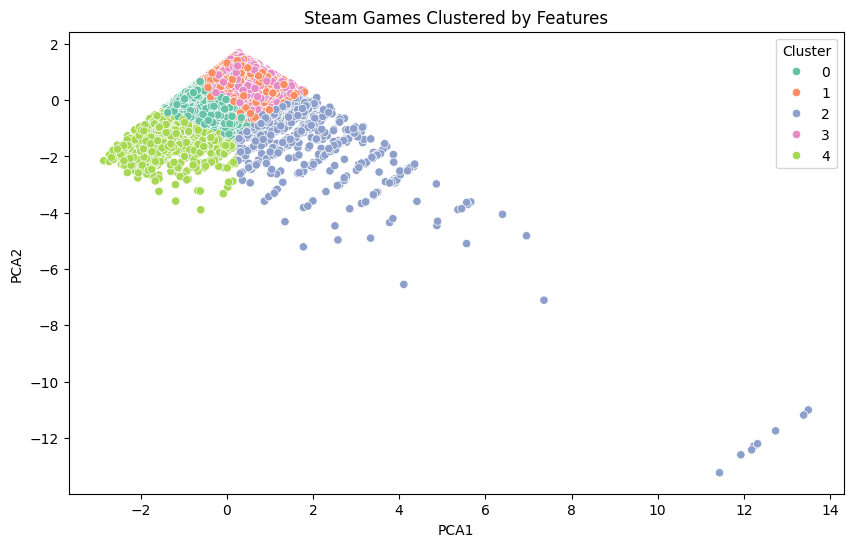

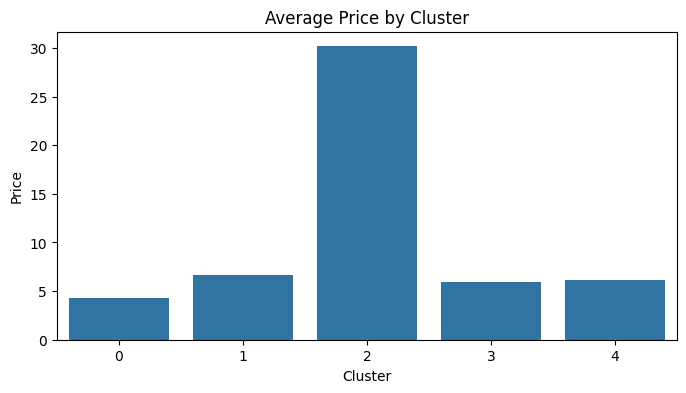

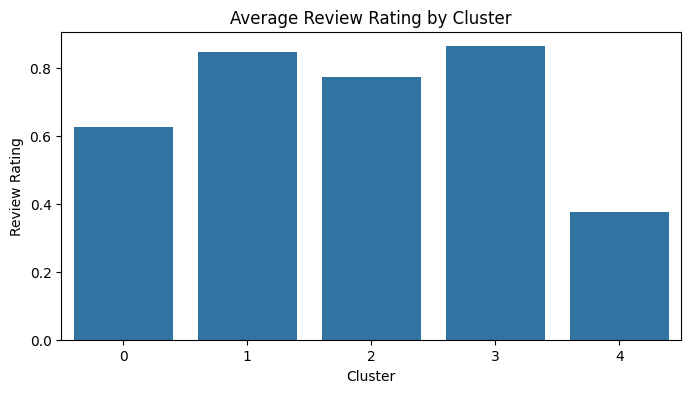

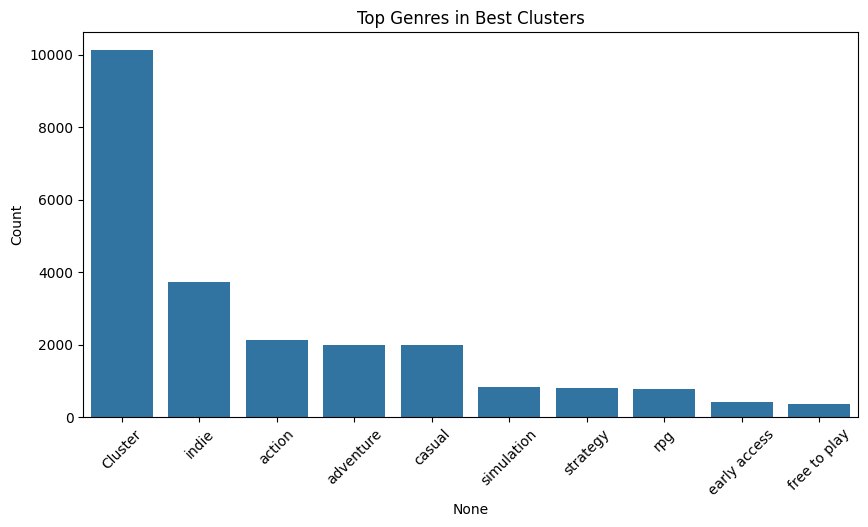

🔍 Cluster 3 Stats:
             Price  Review Rating
count  2662.000000    2662.000000
mean      5.985154       0.864491
std       5.168662       0.069845
min       0.000000       0.714286
25%       1.490000       0.806857
50%       4.990000       0.868421
75%       9.990000       0.923077
max      19.990000       0.993151

🎮 Top Games in Cluster 3:
                                                  Name  Price  Review Rating  \
8524   Escape Lala 2 - Retro Point and Click Adventure   4.99       0.993151   
12748                  Deathbulge: Battle of the Bands  19.99       0.993039   
12390                                       Penko Park  13.99       0.992110   
3583                                        Nodebuster   2.99       0.991667   
8399                               The Crimson Diamond  14.99       0.991632   
14602                                      Chessformer   2.49       0.991632   
3237                      A Shopping Trip to Eklan Tor   0.00       0.990909   
13174   

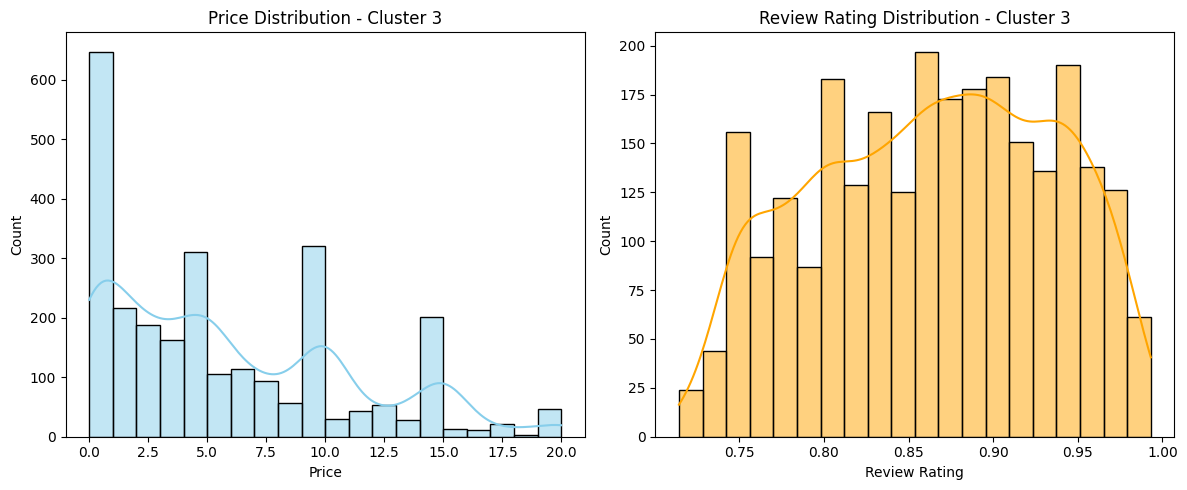

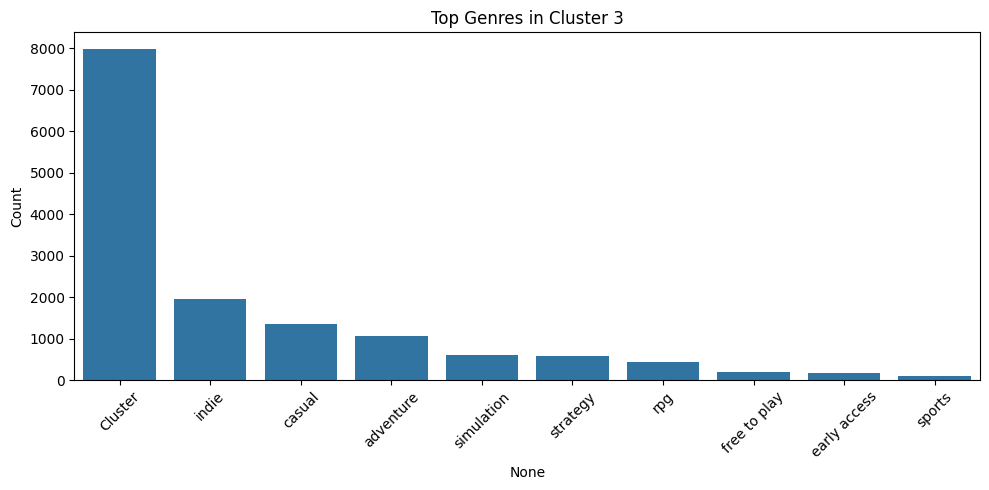

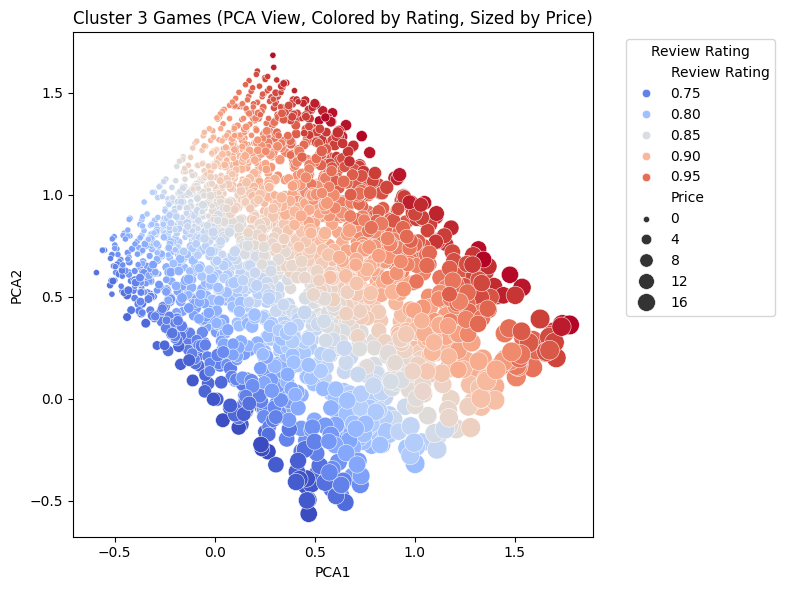

In [ ]:
# --- Install kagglehub (run once) ---
!pip install kagglehub

# --- Imports ---
import os
import kagglehub
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import re

# --- Load Dataset ---
path = kagglehub.dataset_download("joebeachcapital/top-1000-steam-games")
df = pd.read_csv(os.path.join(path, "93182_steam_games.csv"))

# Filtering

# Remove games with non-ASCII characters in the title
df = df[df['Name'].apply(lambda x: isinstance(x, str) and bool(re.match(r'^[\x00-\x7F]*$', x)))]
print(f"Step 13: After removing non-ASCII titles: {len(df)}")

# Filter out games with adult content and inappropriate genres
excluded_genres = ['Nudity', 'Sexual Content', 'Mature']

#Remove games with unwanted genres
df = df[~df['Genres'].str.contains('|'.join(excluded_genres), case=False, na=False)]
print(f"Step 2: After filtering adult genres: {len(df)}")

# Filter out games that don't have positive or negative reviews
df = df[(df['Positive'] > 0) & (df['Negative'] > 0)]
print(f"Number of games with valid reviews: {len(df)}")

# Calculate the review rating as Positive / (Positive + Negative)
df['Review Rating'] = df['Positive'] / (df['Positive'] + df['Negative'])

# Remove adult games and unwanted genres
print(f"Step 1: Loaded games: {len(df)}")

# Remove games with the "Romance" tag
df = df[~df['Tags'].str.contains('Romance', case=False, na=False)]
df = df[df['Genres'].notna()]

# filtering out inappropriate words from title
df = df[~df['Name'].str.contains('waifu', case=False, na=False)]
df = df[~df['Name'].str.contains('dating', case=False, na=False)]
df = df[~df['Name'].str.contains('cute', case=False, na=False)]

df = df[['Name', 'Price', 'Review Rating', 'Genres']].copy()
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Review Rating'] = pd.to_numeric(df['Review Rating'], errors='coerce')
df = df.dropna()


df = df[['Name', 'Price', 'Review Rating', 'Genres']].copy()
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Review Rating'] = pd.to_numeric(df['Review Rating'], errors='coerce')
df = df.dropna()
df = df[df['Review Rating'] > 0]
print(f"Step 5: With valid review rating > 0: {len(df)}")

if df['Genres'].empty:
    raise ValueError("No games left after filtering — adjust your filters or check the dataset.")
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','), binary=True)
genre_matrix = vectorizer.fit_transform(df['Genres'])
genre_df = pd.DataFrame(genre_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

scaler = StandardScaler()
scaled = scaler.fit_transform(df[['Price', 'Review Rating']])
scaled_df = pd.DataFrame(scaled, columns=['Price_scaled', 'Rating_scaled'], index=df.index)

features = pd.concat([scaled_df, genre_df], axis=1)

print(f"Number of games after filtering: {len(df)}")

num_samples = features.shape[0]
num_clusters = min(5, num_samples)

if num_samples < 2:
    raise ValueError("Not enough data points after filtering to perform clustering.")

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
df['Cluster'] = kmeans.fit_predict(features)

# Cluster Stats
cluster_stats = df.groupby('Cluster')[['Price', 'Review Rating']].mean()
print("Cluster Averages:")
print(cluster_stats)

# Best Clusters
best_clusters = cluster_stats[(cluster_stats['Price'] < 10) & (cluster_stats['Review Rating'] > 0.8)].index
top_games = df[df['Cluster'].isin(best_clusters)]

print("\nTop Games:")
print(top_games[['Name', 'Price', 'Review Rating', 'Genres']].sort_values(by='Review Rating', ascending=False).head(20))

# cluster with the highest average price
expensive_cluster_id = cluster_stats['Price'].idxmax()

# Filter games in that cluster and sort by review rating
top_value_in_expensive_cluster = df[df['Cluster'] == expensive_cluster_id].sort_values(by='Review Rating', ascending=False)

print(f"Top-rated games in the most expensive cluster (Cluster {expensive_cluster_id}):")
print(top_value_in_expensive_cluster[['Name', 'Price', 'Review Rating', 'Genres']].head(20))


# data by cluster
genre_df['Cluster'] = df['Cluster']
genre_by_cluster = genre_df.groupby('Cluster').sum()

# top 3 genres for each cluster
dominant_genres = {}
for cluster_id, row in genre_by_cluster.iterrows():
    top_genres = row.sort_values(ascending=False).head(3).index.tolist()
    dominant_genres[cluster_id] = top_genres

print("\nDominant genres per cluster:")
for cluster, genres in dominant_genres.items():
    print(f"Cluster {cluster}: {', '.join(genres)}")


# PCA Visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title("Steam Games Clustered by Features")
plt.show()

# Cluster Barplots
plt.figure(figsize=(8, 4))
sns.barplot(data=cluster_stats.reset_index(), x='Cluster', y='Price')
plt.title("Average Price by Cluster")
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=cluster_stats.reset_index(), x='Cluster', y='Review Rating')
plt.title("Average Review Rating by Cluster")
plt.show()

# Top Genres in Best Clusters
best_genre_df = genre_df.loc[top_games.index]
top_genres = best_genre_df.sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_genres.index, y=top_genres.values)
plt.title("Top Genres in Best Clusters")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

# Focus on Cluster 3
cluster_id = 3
cluster3_df = df[df['Cluster'] == cluster_id]

print(f"Cluster {cluster_id} Stats:")
print(cluster3_df[['Price', 'Review Rating']].describe())

print("\nTop Games in Cluster 3:")
print(cluster3_df[['Name', 'Price', 'Review Rating', 'Genres']].sort_values(by='Review Rating', ascending=False).head(10))

# Price and Rating Distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(cluster3_df['Price'], bins=20, kde=True, color='skyblue')
plt.title(f'Price Distribution - Cluster {cluster_id}')

plt.subplot(1, 2, 2)
sns.histplot(cluster3_df['Review Rating'], bins=20, kde=True, color='orange')
plt.title(f'Review Rating Distribution - Cluster {cluster_id}')

plt.tight_layout()
plt.show()

# Genre Composition in Cluster 3
cluster3_genres = genre_df.loc[cluster3_df.index].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=cluster3_genres.head(10).index, y=cluster3_genres.head(10).values)
plt.title(f"Top Genres in Cluster {cluster_id}")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# PCA Focused on Cluster 3
plt.figure(figsize=(8, 6))
sns.scatterplot(data=cluster3_df, x='PCA1', y='PCA2', hue='Review Rating', palette='coolwarm', size='Price', sizes=(20, 200))
plt.title(f"Cluster {cluster_id} Games (PCA View, Colored by Rating, Sized by Price)")
plt.legend(title="Review Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

